## Lab 6: Feature Engineering

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
titanic = pd.read_csv("~/Desktop/P134/titanic.csv")

In [4]:
# detecting missing values
def display_missing(df):
    for col in df.columns.tolist():
        print(f'{col} column missing values: {df[col].isnull().sum()}')
    print('/n')

display_missing(titanic)


passenger_id column missing values: 0
survived column missing values: 0
pclass column missing values: 0
name column missing values: 0
sex column missing values: 0
age column missing values: 177
sib_sp column missing values: 0
parch column missing values: 0
ticket column missing values: 0
fare column missing values: 0
cabin column missing values: 687
embarked column missing values: 2
/n


In [5]:
# replacing age with median age for 
# corresponding level of passenger class and sex
# done because of moderate correlation between age and survived
age_medians = titanic.groupby(['pclass','sex'])['age'].transform(
    lambda x: x.fillna(x.median())
)
titanic['age'] = titanic['age'].fillna(age_medians)

In [7]:
# looking at passengers missing embarked shows we can replace value with S
# for Southampton
titanic['embarked'] = titanic['embarked'].fillna('S')

In [10]:
# label missing deck values with M to treat as a separate deck
titanic['deck'] = titanic['cabin'].apply(
    lambda x: re.search(r"([A-Z]+)", x).group(0) if pd.notna(x) else "M"
)

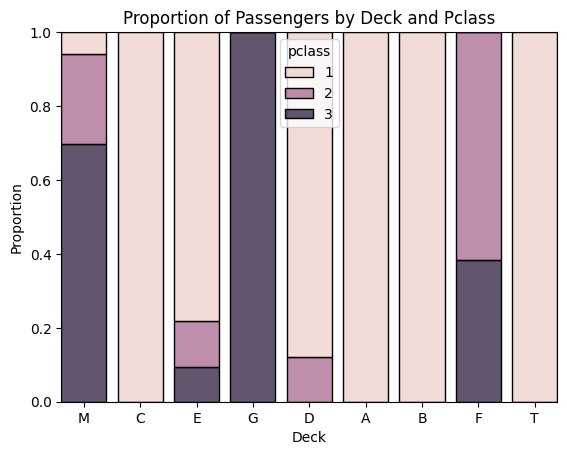

In [12]:
# stacked barchart for passengers by deck and pclass
sns.histplot(data = titanic, x = 'deck', hue = 'pclass',
             multiple = 'fill', shrink = 0.8)
plt.xlabel("Deck")
plt.ylabel("Proportion")
plt.title("Proportion of Passengers by Deck and Pclass")
plt.show()

In [ ]:
# reassigning values for deck column
titanic['deck'] = titanic['deck'].replace({
    'T': 'ABC',
    'A': 'ABC', 'B': 'ABC', 'C': 'ABC',
    'D': 'DE', 'E': 'DE',
    'F': 'FG', 'G': 'FG'
})

# drop cabin column
titanic = titanic.drop(columns = ['cabin'])

In [15]:
# no more missing values
display_missing(titanic)

passenger_id column missing values: 0
survived column missing values: 0
pclass column missing values: 0
name column missing values: 0
sex column missing values: 0
age column missing values: 0
sib_sp column missing values: 0
parch column missing values: 0
ticket column missing values: 0
fare column missing values: 0
embarked column missing values: 0
deck column missing values: 0
/n


### Initial Split

In [16]:
# initial split (stratifying on survived)
titanic_train, titanic_test = train_test_split(titanic, 
                                               test_size = 0.2, 
                                               stratify = titanic['survived'])

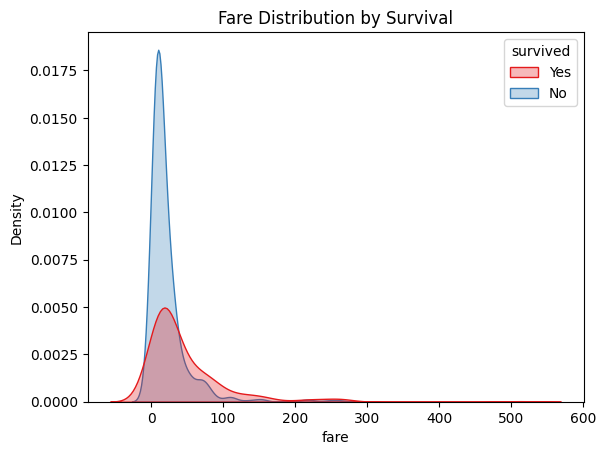

In [17]:
sns.kdeplot(titanic_train, x = 'fare', hue = 'survived', fill = True,
            alpha = 0.3, palette='Set1')
plt.title('Fare Distribution by Survival')
plt.show()

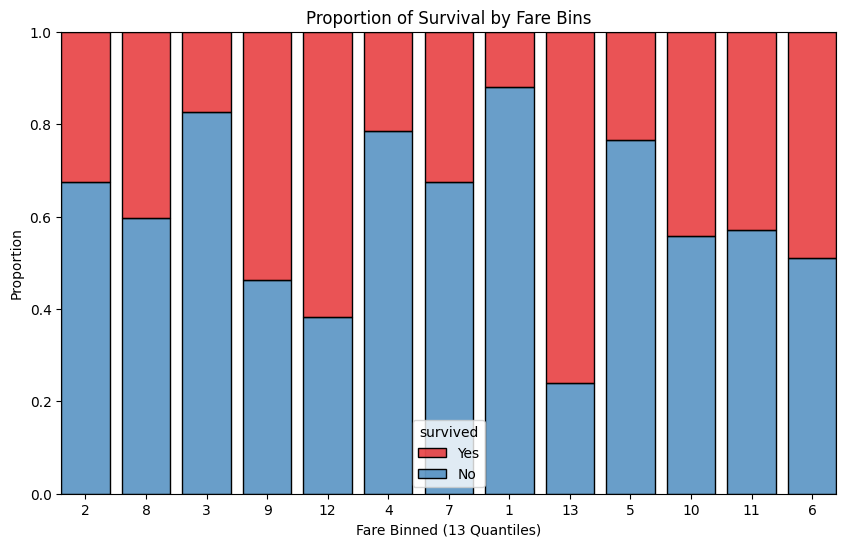

In [18]:
# dividing fare into 13 bins to make stacked proportion bar chart
titanic_train['fare_binned'] = pd.qcut(titanic_train['fare'], q=13, labels=False) + 1
titanic_train['fare_binned'] = titanic_train['fare_binned'].astype(str)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=titanic_train,
    x='fare_binned',
    hue='survived',
    multiple='fill',
    shrink=0.8,
    palette='Set1'
)
plt.xlabel("Fare Binned (13 Quantiles)")
plt.ylabel("Proportion")
plt.title("Proportion of Survival by Fare Bins")
plt.show()

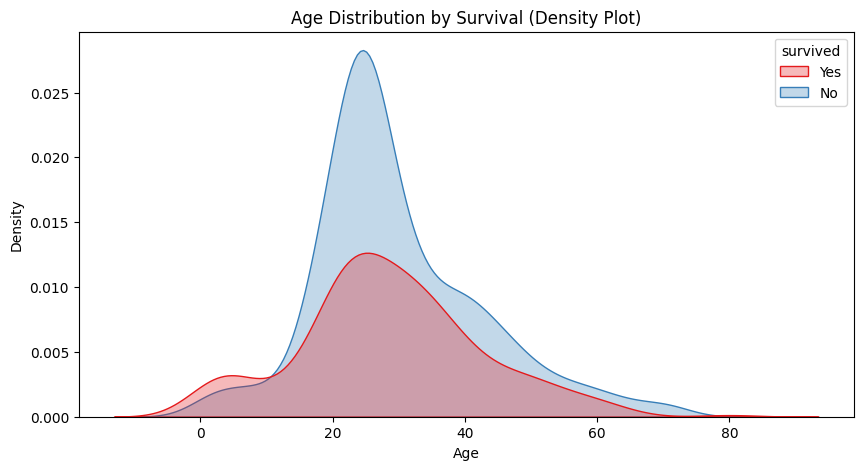

In [19]:
# density plot for age by survived
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=titanic_train, 
    x='age', 
    hue='survived', 
    fill=True, 
    alpha=0.3, 
    palette='Set1'
)
plt.title("Age Distribution by Survival (Density Plot)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

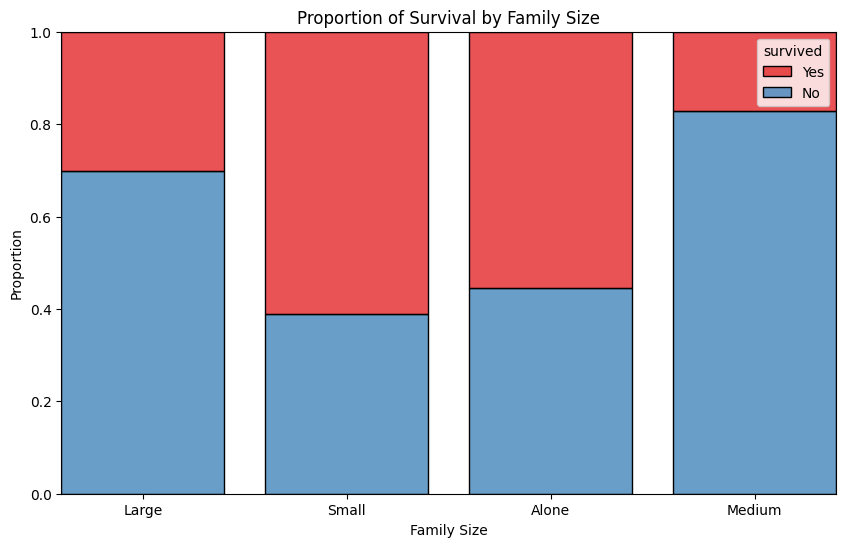

In [20]:
# create new column adding sib_sp and parch
titanic_train['family_size'] = titanic_train['sib_sp'] + titanic_train['parch']

def family_size(size):
    if size == 1:
        return "Alone"
    elif 2 <= size <= 3:
        return "Small"
    elif 4 <= size <= 5:
        return "Medium"
    else:
        return "Large"
    
titanic_train['family_size'] = titanic_train['family_size'].apply(family_size)

# proportion bar chart for survived by family_size
plt.figure(figsize=(10, 6))
sns.histplot(
    data=titanic_train, 
    x='family_size', 
    hue='survived', 
    multiple='fill', 
    shrink=0.8, 
    palette='Set1'
)
plt.xlabel("Family Size")
plt.ylabel("Proportion")
plt.title("Proportion of Survival by Family Size")
plt.show()

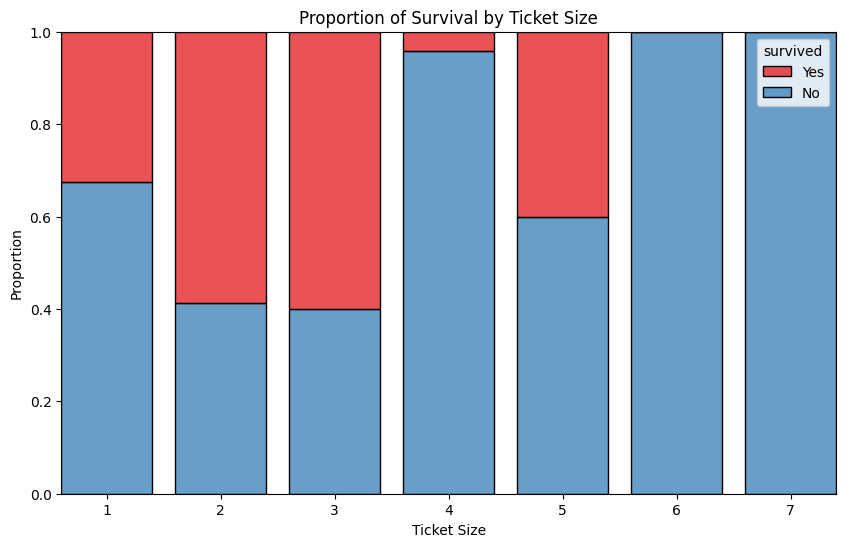

In [26]:
# creating and plotting ticket_size
ticket_sizes = titanic_train.groupby('ticket').size().reset_index(name = 'ticket_size')

titanic_train = titanic_train.merge(ticket_sizes, on = 'ticket')

titanic_train['ticket_size'] = titanic_train['ticket_size'].astype('category')

plt.figure(figsize=(10, 6))
sns.histplot(
    data=titanic_train, 
    x='ticket_size', 
    hue='survived', 
    multiple='fill', 
    shrink=0.8, 
    palette='Set1'
)
plt.xlabel("Ticket Size")
plt.ylabel("Proportion")
plt.title("Proportion of Survival by Ticket Size")
plt.show()

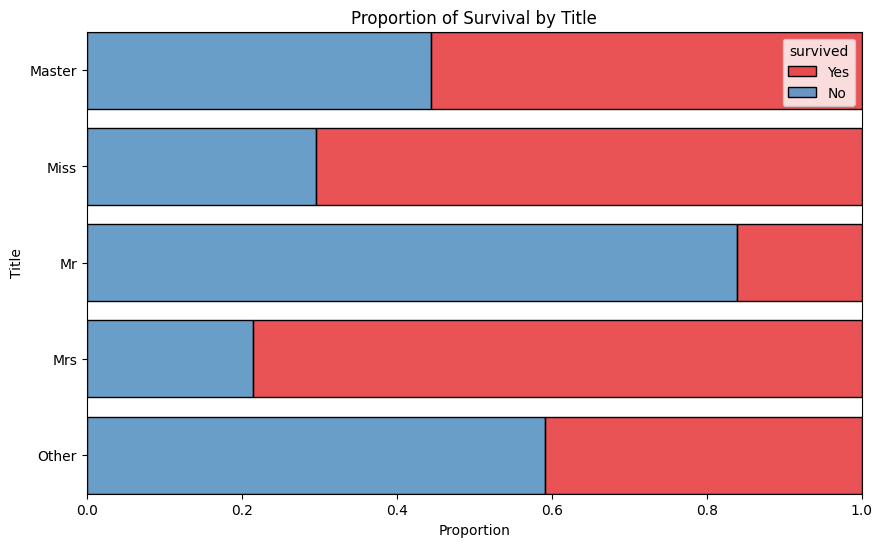

In [25]:
# combining and plotting titles by survied
titanic_train['title'] = titanic_train['name'].apply(lambda x: re.search(r",\s*(.*?)(\.|$)", x).group(1) if re.search(r",\s*(.*?)(\.|$)", x) else None)

title_counts = titanic_train['title'].value_counts()

top_titles = title_counts.nlargest(4).index
titanic_train['title'] = titanic_train['title'].where(titanic_train['title'].isin(top_titles), 'Other')

titanic_train['title'] = titanic_train['title'].astype('category')

plt.figure(figsize=(10, 6))
sns.histplot(
    data=titanic_train, 
    y='title', 
    hue='survived', 
    multiple='fill', 
    shrink=0.8, 
    palette='Set1'
)
plt.ylabel("Title")
plt.xlabel("Proportion")
plt.title("Proportion of Survival by Title")
plt.show()

In [ ]:
# putting it all together
# Process the training dataset
titanic_train = titanic_train.drop(columns=['ticket', 'passenger_id', 'name', 'sib_sp', 'parch', 'fare'])
titanic_train['survived'] = titanic_train['survived'].astype('category')

titanic_train['survived'] = titanic_train['survived'].map({'Yes': 1, 'No': 0})

# Process the test dataset
titanic_test['fare_binned'] = pd.qcut(titanic_test['fare'], q=13, labels=False) + 1

titanic_test['family_size'] = titanic_test['sib_sp'] + titanic_test['parch'] + 1

def categorize_family_size(size):
    if size == 1:
        return "Alone"
    elif 2 <= size <= 3:
        return "Small"
    elif 4 <= size <= 5:
        return "Medium"
    else:
        return "Large"

titanic_test['family_size'] = titanic_test['family_size'].apply(categorize_family_size)

ticket_sizes = titanic_test.groupby('ticket').size().reset_index(name='ticket_size')
titanic_test = titanic_test.merge(ticket_sizes, on='ticket')

titanic_test['ticket_size'] = titanic_test['ticket_size'].astype('category')

titanic_test['title'] = titanic_test['name'].apply(lambda x: re.search(r",\s*(.*?)(\.|$)", x).group(1) if re.search(r",\s*(.*?)(\.|$)", x) else None)

title_counts = titanic_test['title'].value_counts()

top_titles = title_counts.nlargest(4).index
titanic_test['title'] = titanic_test['title'].where(titanic_test['title'].isin(top_titles), 'Other')

titanic_test['title'] = titanic_test['title'].astype('category')

titanic_test = titanic_test.drop(columns=['ticket', 'passenger_id', 'name', 'sib_sp', 'parch', 'fare'])

# One-hot encode categorical features for training and test sets
titanic_train = pd.get_dummies(titanic_train, drop_first=False)
titanic_test = pd.get_dummies(titanic_test, drop_first=False)

# Align columns of training and testing data to ensure they have the same feature set
titanic_train, titanic_test = titanic_train.align(titanic_test, join='outer', axis=1, fill_value=0)

# Show final datasets
print(titanic_train.head())